# Azure AI Foundry

<center><img src="../../images/Azure-AI-Foundry_1600x900.jpg" alt="Azure AI Foundry" width="600">

## Laboratório 1

Neste laboratório iremos realizar a conexão com o Azure OpenAI e executar diversas tarefas: solicitar respostas da API, usar respostas baseadas em texto, analisar as respostas obtidas, realizar a conversão de texto em embeddings, fazer chamadas à API enviando imagens e também realizar chamadas a outros modelos LLM.

O primeiro passo é a validação da configuração das variáveis de ambiente no arquivo `.env` presente na raiz do repositório.

Preencha os valores das variáveis de acordo com o solicitado.

### Exercício 1 - Chamada à API

Vamos realizar a importação das bibliotecas necessárias para o laboratório.

In [1]:
import json
import os
from openai import AzureOpenAI
from dotenv import load_dotenv

load_dotenv(dotenv_path="../../.env")

True

Vamos carregar as credenciais em variáveis para facilitar o uso no laboratório.

In [2]:
azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT"), 
api_key=os.getenv("AZURE_OPENAI_API_KEY"),  
api_version=os.getenv("API_VERSION")
deployment_name = os.getenv("AZURE_OPENAI_DEPLOYMENT")
embedding_model = os.getenv("AZURE_OPENAI_EMBEDDING_MODEL")

Agora vamos iniciar o client com as credenciais fornecidas.

In [3]:
client = AzureOpenAI(
  azure_endpoint = azure_endpoint[0], 
  api_key=api_key[0],  
  api_version=api_version
)


Após criarmos o cliente, vamos realizar uma chamada simples onde passaremos:

1. Uma mensagem para a role "system" definindo o papel da LLM
2. Uma pergunta inicial do usuário
3. Uma resposta do assistente demonstrando como ele deve responder (exemplo)
4. Uma nova pergunta para ele responder baseado no contexto estabelecido anteriormente

In [4]:
response = client.chat.completions.create(
    model=deployment_name, 
    messages=[
        {"role": "system", "content": "Você é um assistente útil."},
        {"role": "user", "content": "O Azure OpenAI suporta chaves gerenciadas pelo cliente?"},
        {"role": "assistant", "content": "Sim, chaves gerenciadas pelo cliente são suportadas pelo Azure OpenAI."},
        {"role": "user", "content": "Outros serviços do Azure também suportam isso?"}
    ]
)

Agora vamos acessar diretamente a resposta da LLM.

In [5]:
print(response.choices[0].message.content)

Sim, diversos outros serviços do Azure suportam chaves gerenciadas pelo cliente (Customer Managed Keys – CMK). Estas chaves permitem que você tenha controle adicional sobre a criptografia dos dados armazenados nos serviços do Azure, podendo gerenciar, revogar ou renovar as chaves conforme necessidade, normalmente utilizando o Azure Key Vault.

**Exemplos de serviços do Azure que suportam CMK:**

- **Azure Storage Account (Blob, File, Queue, Table)**
- **Azure Data Lake Storage**
- **Azure SQL Database**
- **Azure Cosmos DB**
- **Azure Disk Storage**
- **Azure Synapse Analytics**
- **Azure Data Factory**
- **Azure Cognitive Services**
- **Azure Machine Learning**
- **Azure Kubernetes Service (AKS)**
- **Azure Key Vault** (para gerenciamento das próprias chaves)
- **Azure Backup**

A implementação e os recursos podem variar de acordo com o serviço, então é importante consultar a documentação específica de cada serviço para detalhes sobre como configurar o uso de CMK.

Se você quiser sabe

### Exercício 2 - Analisando a Resposta

Agora que fizemos uma chamada para o Azure OpenAI, vamos analisar o conteúdo completo da resposta:

In [6]:
response

ChatCompletion(id='chatcmpl-Bnq489wZZWKfdgmR1SgXygOsi5Y8e', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Sim, diversos outros serviços do Azure suportam chaves gerenciadas pelo cliente (Customer Managed Keys – CMK). Estas chaves permitem que você tenha controle adicional sobre a criptografia dos dados armazenados nos serviços do Azure, podendo gerenciar, revogar ou renovar as chaves conforme necessidade, normalmente utilizando o Azure Key Vault.\n\n**Exemplos de serviços do Azure que suportam CMK:**\n\n- **Azure Storage Account (Blob, File, Queue, Table)**\n- **Azure Data Lake Storage**\n- **Azure SQL Database**\n- **Azure Cosmos DB**\n- **Azure Disk Storage**\n- **Azure Synapse Analytics**\n- **Azure Data Factory**\n- **Azure Cognitive Services**\n- **Azure Machine Learning**\n- **Azure Kubernetes Service (AKS)**\n- **Azure Key Vault** (para gerenciamento das próprias chaves)\n- **Azure Backup**\n\nA implementação e os recursos p

Agora vamos estruturar a resposta em um formato mais legível para melhor visualização dos dados:

In [7]:
response_dict = {
    "id": response.id,
    "model": response.model,
    "created": response.created,
    "usage": {
        "prompt_tokens": response.usage.prompt_tokens,
        "completion_tokens": response.usage.completion_tokens,
        "total_tokens": response.usage.total_tokens
    },
    "completion_tokens_details": {
        "accepted_prediction_tokens": response.usage.completion_tokens_details.accepted_prediction_tokens,
        "audio_tokens": response.usage.completion_tokens_details.audio_tokens,
        "reasoning_tokens": response.usage.completion_tokens_details.reasoning_tokens,
        "rejected_prediction_tokens": response.usage.completion_tokens_details.rejected_prediction_tokens
    },
    "choices": [{
        "index": choice.index,
        "message": {
            "role": choice.message.role,
            "content": choice.message.content
        },
        "finish_reason": choice.finish_reason,
        "content_filter_results": choice.content_filter_results
    } for choice in response.choices],
    "prompt_filter_results": response.prompt_filter_results
}

print(json.dumps(response_dict, indent=2, ensure_ascii=False))

{
  "id": "chatcmpl-Bnq489wZZWKfdgmR1SgXygOsi5Y8e",
  "model": "gpt-4.1-2025-04-14",
  "created": 1751217912,
  "usage": {
    "prompt_tokens": 66,
    "completion_tokens": 230,
    "total_tokens": 296
  },
  "completion_tokens_details": {
    "accepted_prediction_tokens": 0,
    "audio_tokens": 0,
    "reasoning_tokens": 0,
    "rejected_prediction_tokens": 0
  },
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": "Sim, diversos outros serviços do Azure suportam chaves gerenciadas pelo cliente (Customer Managed Keys – CMK). Estas chaves permitem que você tenha controle adicional sobre a criptografia dos dados armazenados nos serviços do Azure, podendo gerenciar, revogar ou renovar as chaves conforme necessidade, normalmente utilizando o Azure Key Vault.\n\n**Exemplos de serviços do Azure que suportam CMK:**\n\n- **Azure Storage Account (Blob, File, Queue, Table)**\n- **Azure Data Lake Storage**\n- **Azure SQL Database**\n- **Azure

A API não responde apenas com o texto gerado pela LLM. Temos muito mais informações nessa resposta, como por exemplo:
- Se usa áudio ou imagem
- Filtragem de conteúdo
- Avaliação de conteúdo
- Contagem de tokens do prompt
- Contagem de tokens gerados na resposta
- Detalhes sobre tokens de raciocínio (para modelos que suportam)
- Resultados de filtros aplicados

Essas informações são essenciais para monitoramento, custos e controle de qualidade da aplicação.

Após realizar a chamada e explorar a resposta, teste você também criando um prompt personalizado. Realize experimentos com os seguintes parâmetros importantes:

- **max_completion_tokens**: Número máximo de tokens que podem ser gerados na resposta
- **temperature**: Controla a criatividade (0.0 = mais determinístico, 1.0 = mais criativo)
- **top_p**: Controla a diversidade da resposta via nucleus sampling
- **frequency_penalty**: Penaliza repetição de tokens baseado na frequência
- **presence_penalty**: Penaliza repetição de tokens independentemente da frequência

In [8]:
response = client.chat.completions.create(
    messages=[
        {
            "role": "system",
            "content": "Você é um assistente útil.",
        },
        {
            "role": "user",
            "content": "Vou viajar para Paris, o que devo ver?",
        },
        {
            "role": "assistant",
            "content": "Paris, a capital da França, é conhecida por sua arquitetura deslumbrante, museus de arte, marcos históricos e atmosfera romântica. Aqui estão algumas das principais atrações para ver em Paris:\n \n 1. A Torre Eiffel: A icônica Torre Eiffel é um dos marcos mais reconhecíveis do mundo e oferece vistas deslumbrantes da cidade.\n 2. O Museu do Louvre: O Louvre é um dos maiores e mais famosos museus do mundo, abrigando uma impressionante coleção de arte e artefatos, incluindo a Mona Lisa.\n 3. Catedral de Notre-Dame: Esta bela catedral é um dos marcos mais famosos de Paris e é conhecida por sua arquitetura gótica e vitrais deslumbrantes.\n \n Estas são apenas algumas das muitas atrações que Paris tem a oferecer. Com tanto para ver e fazer, não é de admirar que Paris seja um dos destinos turísticos mais populares do mundo.",
        },
        {
            "role": "user",
            "content": "O que há de tão especial no #1?",
        }
    ],
    max_completion_tokens=800,
    temperature=1.0,
    top_p=1.0,
    frequency_penalty=0.0,
    presence_penalty=0.0,
    model=deployment_name
)

print(response.choices[0].message.content)

A Torre Eiffel é especial por vários motivos:

**1. Símbolo icônico:** Construída para a Exposição Universal de 1889, comemorando o centenário da Revolução Francesa, ela tornou-se rapidamente o maior símbolo de Paris e, por extensão, da própria França. É reconhecida mundialmente, figurando em filmes, fotografias, obras de arte — representa o romantismo e a elegância francesa.

**2. Engenharia inovadora:** Projetada por Gustave Eiffel, a torre foi uma maravilha da engenharia de sua época. Feita de ferro forjado, com uma altura de 324 metros, foi a estrutura mais alta do mundo até 1930. Sua construção revolucionou o uso de metais na arquitetura e inspirou gerações de engenheiros e arquitetos.

**3. Vista panorâmica:** Subir seus andares (ou ir de elevador) oferece vistas espetaculares de Paris. Lá do alto você pode ver marcos como o Rio Sena, o Sacré-Cœur, o Arco do Triunfo e diversos outros pontos famosos.

**4. Atmosfera única:** À noite, a torre se ilumina e a cada hora ganha um espet

### Exercício 3 - Embeddings

Os embeddings são representações numéricas de texto que capturam o significado semântico das palavras ou frases. No Azure OpenAI, você pode usar o modelo de embeddings para converter texto em vetores numéricos que podem ser usados para tarefas como busca semântica, classificação e análise de similaridade.

Para mais informações sobre como trabalhar com embeddings no Azure OpenAI, consulte a [documentação oficial](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/embeddings?tabs=python-new).

In [9]:
response = client.embeddings.create(
    input = "cachorro",
    model= embedding_model
)

print(response.model_dump_json(indent=2))

{
  "data": [
    {
      "embedding": [
        -0.041610781103372574,
        0.028764210641384125,
        0.009645742364227772,
        0.015888802707195282,
        0.01718643493950367,
        0.029557207599282265,
        -0.031431566923856735,
        0.01552834827452898,
        0.0020383659284561872,
        0.053952720016241074,
        -0.023126713931560516,
        -0.005248206667602062,
        -0.041005220264196396,
        -0.029023736715316772,
        0.0016049203695729375,
        0.013812588527798653,
        -0.014879531227052212,
        -0.010236887261271477,
        -0.00511123426258564,
        -0.0040767318569123745,
        0.010554086416959763,
        -0.00006752875924576074,
        0.026543814688920975,
        0.01007828675210476,
        0.012060782872140408,
        0.03249851241707802,
        -0.013279116712510586,
        0.015888802707195282,
        -0.01574462093412876,
        -0.0012570824474096298,
        -0.036362577229738235,
        0.0107

Aqui geramos o embedding de uma única palavra, mas podemos fazer o mesmo para trechos de texto maiores. O modelo organizará automaticamente o conteúdo em vetores numéricos que capturam o significado semântico.

Para armazenar embeddings podemos usar uma série de serviços disponíveis no Azure. Basta escolher o que mais se adequa à sua solução:

- [Azure AI Search](https://learn.microsoft.com/en-us/azure/search/vector-search-overview)
- [Azure Cosmos DB for MongoDB vCore](https://learn.microsoft.com/en-us/azure/cosmos-db/mongodb/vcore/vector-search)
- [Azure SQL Database](https://learn.microsoft.com/en-us/azure/azure-sql/database/ai-artificial-intelligence-intelligent-applications?view=azuresql&preserve-view=true#vector-search)
- [Azure Cosmos DB for NoSQL](https://learn.microsoft.com/en-us/azure/cosmos-db/vector-search)
- [Azure Cosmos DB for PostgreSQL](https://learn.microsoft.com/en-us/azure/cosmos-db/postgresql/howto-use-pgvector)
- [Azure Database for PostgreSQL - Flexible Server](https://learn.microsoft.com/en-us/azure/postgresql/flexible-server/how-to-use-pgvector)
- [Azure Cache for Redis](https://learn.microsoft.com/en-us/azure/azure-cache-for-redis/cache-tutorial-vector-similarity)
- [Use Eventhouse as a vector database - Real-Time Intelligence in Microsoft Fabric](https://learn.microsoft.com/en-us/fabric/real-time-intelligence/vector-database)

### Exercício 4 - Processamento de Imagens

No Azure AI Foundry podemos trabalhar com modelos que processam imagens, tanto para geração de imagens quanto modelos multimodais nos quais podemos usar imagens como contexto. Neste exercício vamos aprender como utilizar imagens como contexto do prompt.

**Primeiro ponto importante**: temos que pensar em como enviar uma imagem junto ao prompt. Para isso temos 2 opções principais:
1. Enviar a imagem junto com o prompt via base64 (codificada)
2. Enviar a imagem como um link/URL

Vamos ver os 2 exemplos práticos a seguir.

Primeiro, vamos aproveitar o cliente que já instanciamos e enviar uma URL de uma imagem, pedindo para o modelo descrevê-la:

In [10]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Itaim_Bibi_Business_District.jpg/250px-Itaim_Bibi_Business_District.jpg"

In [11]:
response = client.chat.completions.create(
    model=deployment_name,
    messages=[
        { "role": "system", "content": "Você é um assistente útil." },
        { "role": "user", "content": [  
            { 
                "type": "text", 
                "text": "Descreva essa imagem:" 
            },
            { 
                "type": "image_url",
                "image_url": {
                    "url": image_url
                }
            }
        ] } 
    ],
    max_tokens=2000 
)
print(response.choices[0].message.content)

A imagem mostra um moderno centro empresarial durante o entardecer. Em destaque, há diversos arranha-céus de vidro e aparência sofisticada, refletindo o céu azul claro com algumas nuvens. À frente dos prédios, há uma ampla área verde arborizada, com caminhos, jardins e pessoas circulando. No horizonte, vê-se a continuidade da cidade, repleta de outros edifícios e construções. A iluminação já começa a aparecer nas janelas dos prédios, indicando o início da noite. O cenário transmite uma combinação entre urbanização e preservação de espaços verdes.


Agora vamos ler uma imagem local armazenada em nosso sistema e enviá-la junto com a mensagem:

In [12]:
import base64
from mimetypes import guess_type

In [13]:
def local_image_to_data_url(image_path):
    # Guess the MIME type of the image based on the file extension
    mime_type, _ = guess_type(image_path)
    if mime_type is None:
        mime_type = 'application/octet-stream'  # Default MIME type if none is found

    # Read and encode the image file
    with open(image_path, "rb") as image_file:
        base64_encoded_data = base64.b64encode(image_file.read()).decode('utf-8')

    # Construct the data URL
    return f"data:{mime_type};base64,{base64_encoded_data}"

Data URL: 

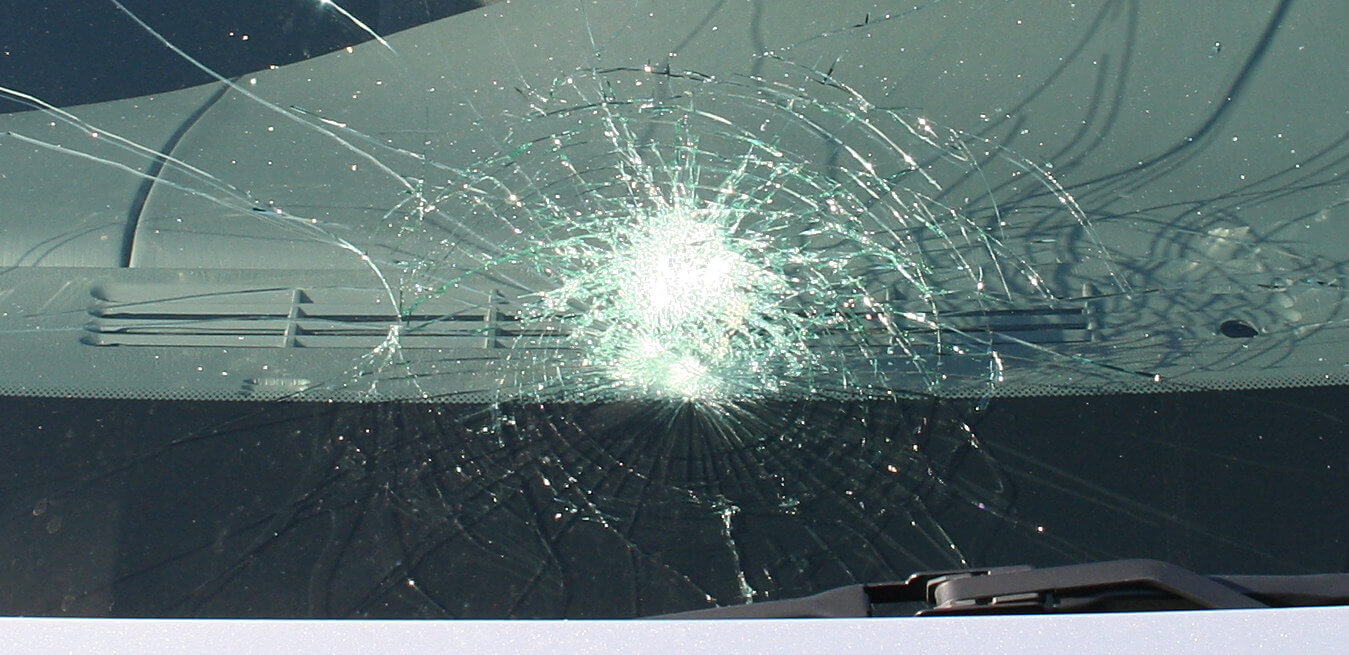

In [14]:
image_path = "../../images/234039841.jpg"
data_url = local_image_to_data_url(image_path)
print("Data URL:", data_url)

In [15]:
response = client.chat.completions.create(
    model=deployment_name,
    messages=[
        { "role": "system", "content": "Você é um assistente útil." },
        { "role": "user", "content": [  
            { 
                "type": "text", 
                "text": "Descreva essa imagem:" 
            },
            { 
                "type": "image_url",
                "image_url": {
                    "url": data_url
                }
            }
        ] } 
    ],
    max_tokens=2000 
)
print(response.choices[0].message.content)

Esta imagem mostra um para-brisa de carro com um grande dano no vidro, localizado no centro. O vidro está bastante trincado, apresentando uma rachadura em formato circular com várias linhas irradiando a partir do ponto de impacto, sugerindo que algo atingiu o para-brisa com força considerável. O dano provoca um padrão de estilhaçamento, típico de vidros laminados automotivos. Também é possível ver parte do limpador de para-brisa na parte inferior da imagem.


Utilizando o Azure OpenAI temos acesso a diversos tipos de funcionalidades além das que exploramos aqui. Recomendo navegar e explorar as opções disponíveis para entender qual é a melhor abordagem para sua aplicação específica:

- [Responses API](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/responses)
- [Reasoning Models](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/reasoning)
- [Chat completions API](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/chatgpt)
- [Computer Use](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/computer-use)
- [Model router concepts](https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/model-router)
- [Function calling](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/function-calling)
- [Predicted outputs](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/predicted-outputs)
- [Prompt caching](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/prompt-caching)
- [Structured outputs](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/structured-outputs)
- [Vision-enabled chats](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/structured-outputs)
- [JSON Mode](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/json-mode)
- [Reproducible output](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/reproducible-output)

### Exercício 5 - Outros modelos no Azure AI Foundry

Através do Azure AI Foundry podemos explorar uma série de modelos disponíveis no [Model Catalog](https://learn.microsoft.com/en-us/azure/ai-foundry/concepts/foundry-models-overview). 

Lá temos acesso a modelos que são disponibilizados pela Microsoft (OpenAI, Meta, Mistral AI, Deepseek, xAI, Black Forest Labs) bem como modelos disponibilizados por parceiros e pela comunidade (Nixtla, AI21, NTT Data, Core42, NVIDIA NIM Microservices, Stability AI). 

Através da documentação fornecida é possível entender a diferença entre os diferentes modos de disponibilização dos modelos e como escolher de acordo com seu cenário específico.



Agora vamos seguir com um exemplo prático de como chamar um modelo disponibilizado pelo Azure AI Foundry através de uma chamada de chat completion usando uma biblioteca diferente da anterior:

In [28]:
from azure.ai.inference import ChatCompletionsClient
from azure.core.credentials import AzureKeyCredential
from azure.ai.inference.models import AssistantMessage, SystemMessage, UserMessage

In [22]:
endpoint = os.getenv("AZURE_PHI4_ENDPOINT")
api_key = os.getenv("AZURE_PHI4_API_KEY")
model_name = os.getenv("AZURE_PHI4_DEPLOYMENT")


In [25]:
client = ChatCompletionsClient(
    endpoint=endpoint,
    credential=AzureKeyCredential(api_key),
    api_version=os.getenv("AZURE_PHI4_API_VERSION")
)

In [31]:
response = client.complete(
    messages=[
        SystemMessage(content="Você é um assistente útil."),
        UserMessage(content="Vou viajar para Paris, o que devo ver?"),
    ],
    max_tokens=2048,
    temperature=0.8,
    top_p=0.1,
    presence_penalty=0.0,
    frequency_penalty=0.0,
    model=model_name
)

print(response.choices[0].message.content)

Paris is a city rich in history, culture, and beauty, offering a wide array of attractions. Here are some must-see places and experiences:

1. **Eiffel Tower**: No visit to Paris is complete without seeing this iconic landmark. You can take an elevator to the top for breathtaking views of the city.

2. **Louvre Museum**: Home to thousands of works of art, including the Mona Lisa and the Venus de Milo, the Louvre is one of the world's largest and most visited museums.

3. **Notre-Dame Cathedral**: Although it suffered a fire in 2019, the cathedral remains a masterpiece of French Gothic architecture. You can admire its exterior and the ongoing restoration efforts.

4. **Champs-Élysées and Arc de Triomphe**: Stroll down this famous avenue, ending at the Arc de Triomphe, where you can climb to the top for panoramic views of Paris.

5. **Montmartre and Sacré-Cœur Basilica**: Explore the charming neighborhood of Montmartre, known for its artistic history, and visit the stunning Sacré-Cœur Ba